Epoch [1/10] - Train Acc: 98.80%, Val Acc: 97.09% | Train Loss: 0.0350, Val Loss: 0.1576
Epoch [2/10] - Train Acc: 99.98%, Val Acc: 96.12% | Train Loss: 0.0019, Val Loss: 0.0980
Epoch [3/10] - Train Acc: 99.75%, Val Acc: 95.15% | Train Loss: 0.0085, Val Loss: 0.0732
Epoch [4/10] - Train Acc: 99.85%, Val Acc: 99.03% | Train Loss: 0.0072, Val Loss: 0.0575
Epoch [5/10] - Train Acc: 99.89%, Val Acc: 95.15% | Train Loss: 0.0043, Val Loss: 0.0821
Epoch [6/10] - Train Acc: 99.96%, Val Acc: 99.03% | Train Loss: 0.0017, Val Loss: 0.0299
Epoch [7/10] - Train Acc: 99.83%, Val Acc: 89.32% | Train Loss: 0.0059, Val Loss: 0.1927
Epoch [8/10] - Train Acc: 99.94%, Val Acc: 98.06% | Train Loss: 0.0023, Val Loss: 0.0438
Epoch [9/10] - Train Acc: 99.92%, Val Acc: 88.35% | Train Loss: 0.0015, Val Loss: 0.2495
Epoch [10/10] - Train Acc: 99.90%, Val Acc: 97.09% | Train Loss: 0.0024, Val Loss: 0.0907
✅ Training complete. Model saved as 'vit_base_final.pt'.


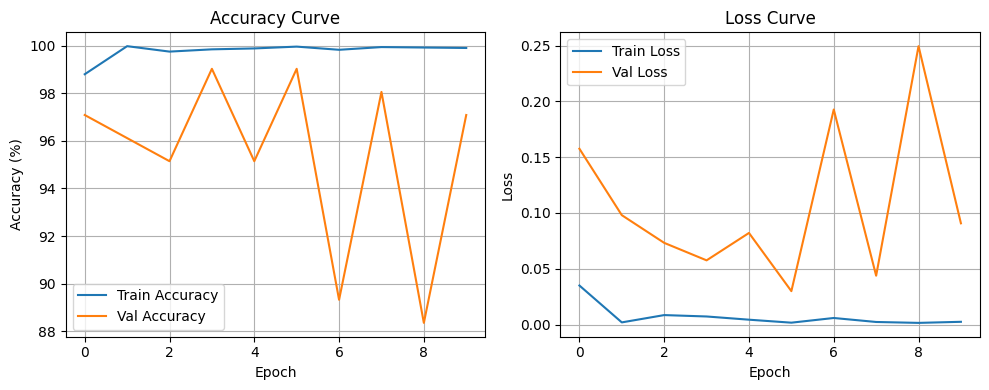

In [ ]:
import os
import torch
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from timm import create_model
import cv2

# Set reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Augmentation and transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Paths
train_path = '/content/drive/MyDrive/5000 IMAGES'
val_path = '/content/drive/MyDrive/VALIDATION'

# Datasets & loaders
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)
class_names = train_dataset.classes

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Evaluation
def evaluate(model, dataloader, criterion):
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct / total, val_loss / len(dataloader)

# Training loop
def train_model(model, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total, correct = 0, 0
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate(model, val_loader, criterion)
        train_loss = running_loss / len(train_loader)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}% | "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    torch.save(model.state_dict(), "vit_base_final.pt")
    print("✅ Training complete. Model saved as 'vit_base_final.pt'.")

    # Plot accuracy & loss
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Main model setup
def train_transformer():
    model = create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=2,
        drop_rate=0.3,
        drop_path_rate=0.2
    )
    train_model(model, epochs=10)

# Run
if __name__ == "__main__":
    train_transformer()


📝 Classification Report:
                precision    recall  f1-score   support

Cracked images       0.97      0.98      0.97        58
     UNCRACKED       0.98      0.96      0.97        45

      accuracy                           0.97       103
     macro avg       0.97      0.97      0.97       103
  weighted avg       0.97      0.97      0.97       103



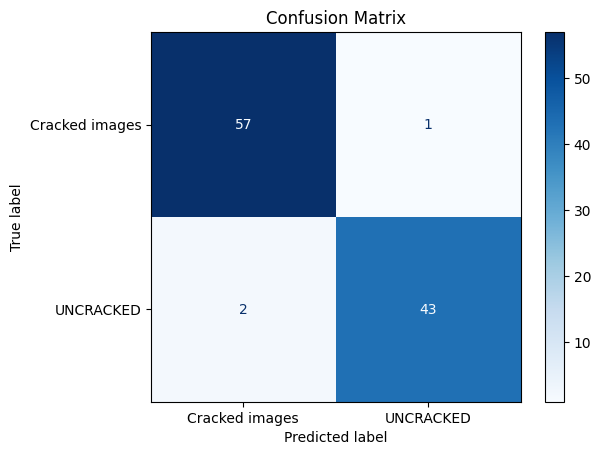

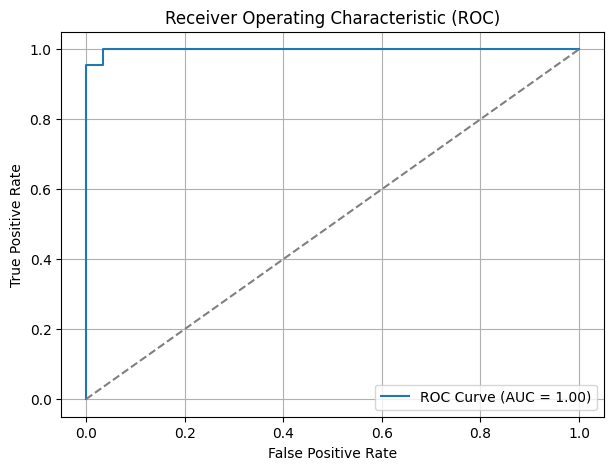

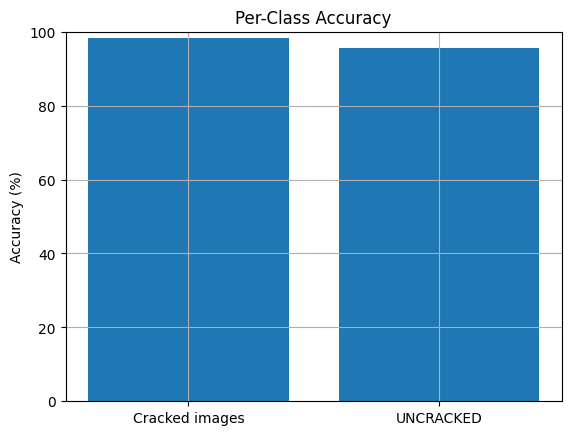

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import cv2
from timm import create_model

# Set device and paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/vit_base_final.pt'
val_dir = '/content/drive/MyDrive/VALIDATION'

# Validation dataset
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
class_names = val_dataset.classes

# Load trained ViT model
def load_model(path):
    model = create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Evaluate ViT model
def evaluate_model(model, dataloader):
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)

            y_scores.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\n📝 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.grid(True)
    plt.show()

    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    for i in range(len(y_true)):
        label = y_true[i]
        class_total[label] += 1
        if y_pred[i] == label:
            class_correct[label] += 1

    acc_per_class = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]
    plt.bar(class_names, acc_per_class)
    plt.ylabel("Accuracy (%)")
    plt.title("Per-Class Accuracy")
    plt.ylim([0, 100])
    plt.grid(True)
    plt.show()

# Run
model = load_model(model_path)
evaluate_model(model, val_loader)